In [1]:
#!pip install lxml

In [2]:
from bs4 import BeautifulSoup
import re
import nltk
import torch
import summa
import numpy as np
import pandas as pd
import urllib.request
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from importlib.metadata import version
from collections import Counter
import requests
from summa.summarizer import summarize
import copy

In [3]:
nltk.download('stopwords')
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
data.sample(10)

,headlines,text
48963,HC slams lawyer who said women are 'gateway to...,The Delhi HC has warned a lawyer of strict act...
72270,"Free International Calls, only on Vodafone RED...",Users can enjoy free international calls along...
87392,Comments on MS Dhoni taken out of context: Har...,"Spinner Harbhajan Singh, who failed to make it..."
14186,PMO seeks report as 22 test positive for Zika ...,The Prime Minister's Office has sought a repor...
34933,"Be courteous, polite to taxpayers: I-T Dept to...",The Income Tax Department has issued directive...
18189,She fought for her life: Serena's husband crea...,Serena Williams' husband Alexis Ohanian create...
30145,Cricket match was once delayed due to life-siz...,"On May 21, 2011, a cricket match between South..."
11091,BJP Delhi chief clashes with AAP members at Si...,BJP Delhi chief Manoj Tiwari and BJP supporter...
79195,Not briefing Tata Trusts on my every move: N C...,Tata Sons Chairman N Chandrasekaran has said h...
49628,Hyd varsity suspends student for abusing Dalit...,The University of Hyderabad has suspended a re...


In [5]:
#데이터 분석 함수
#===============================================================================================================================#
def below_threshold_len(max_len, data, features):
    max_len_list = []
    # 두 입력의 길이가 맞지 않다면 맞춰주기
    if len(max_len) < len(features):
        max_len_list = [max_len for _ in range(len(features) - len(max_len))]
    elif len(max_len) > len(features):
        max_len_list = max_len[:len(features)]
    else:
        max_len_list = max_len
    
    for idx, feature in enumerate(features):
        cnt=0
        for s in data[feature]:
            if(len(s.split())<=max_len_list[idx]):
                cnt = cnt+1
        print('전체 %s 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(feature ,max_len_list[idx], (cnt / len(data[feature]))))

#데이터 길이 시각화 함수
def DataLengthVisualization(data, features, bins=40):
    
    #가변 길이 처리하기위한 dictionary
    container = dict()

    for idx, feature in enumerate(features):
        container[feature] = [len(s.split()) for s in data[feature]]
    
        print('{}의 최소 길이 : {}'.format(feature, np.min(container[feature])))
        print('{}의 최대 길이 : {}'.format(feature, np.max(container[feature])))
        print('{}의 평균 길이 : {}'.format(feature, np.mean(container[feature])))
    
        plt.subplot(1,len(features),idx+1)
        plt.boxplot(container[feature])
        plt.title(feature)
        
    plt.tight_layout()
    plt.show()

    for idx, feature in enumerate(features):
    
        plt.title(feature)
        plt.hist(container[feature],bins=bins)
        plt.xlabel('length of samples')
        plt.ylabel('number of samples')
        plt.show()

#희귀 단어 파악
def spase_word(data, features, threshold=7):

    #가변 길이 처리하기위한 dictionary
    container = dict()
    
    for feature in features:
        container[feature] = data[feature].tolist()
        
        # 단어 빈도수 계산
        word_counter = Counter()
        for text in container[feature]:
            word_counter.update(text.split())
        
        total_cnt = len(word_counter)  # 전체 단어 개수
        total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
        rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
        rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수
        
        # 희귀 단어를 제외한 단어 사전 구축
        vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
        word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

        print('대상 feature : ', feature)
        print('단어 집합(vocabulary)의 크기 :', total_cnt)
        print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
        print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
        print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
        print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
        print("=======================================================================")

In [6]:
#정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

# 텐서 변환 함수 (리스트 → PyTorch 텐서)
def convert_to_tensor(sequences):
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수 (PyTorch `pad_sequence()` 활용)
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    sequences = convert_to_tensor(sequences)  # 리스트를 텐서로 변환
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=padding_value)  # 패딩 적용
    return padded_seqs[:, :maxlen]  # maxlen 길이로 자르기 (최대 길이 초과 방지)

def text_to_sequence(texts, vocab, src_tokenizer):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

def tokenizer(text): # 토크나이저 정의
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

def preprocessing(data, contractions, features, features_max_len, 
                  encode=None ,target = None, remove_stopwords=True, 
                  src_max_len = 50, tar_max_len = 8, src_vocab_size=8000, 
                  tar_vocab_size=2000, train_ratio = 0.8, padding_value=0,
                  verbose=0):
    if len(features) < 2:
        raise Exception("Input length of features must larger than 2")

    if verbose >= 3:
        data = data[features]
        data.sample(15)

    # 입력 없으면 첫번째를 input, 마지막을 target으로 설정
    if encode is None:
        encode = features[0]
    if target is None:
        target = features[-1]

    if train_ratio > 1:
        train_ratio = 0.8
    
    data.drop_duplicates(subset=encode, inplace=True)
    if data.isnull().sum().sum() > 0:
        data.dropna(axis=0, inplace=True)

    # feature 마다 max len을 담고있는 list
    if len(features) != len(features_max_len):
        raise Exception("Input length of features does not match to features_max_len")
    
    for feature, feature_len in zip(features, features_max_len):
        temp_data = []
        for sentence in data[feature]:
            if feature == target:
                temp_data.append(preprocess_sentence(sentence,remove_stopwords=False))
            else:
                temp_data.append(preprocess_sentence(sentence))
            
        data[feature] = temp_data
        data = data[data[feature].apply(lambda x: len(x.split()) <= feature_len)]

    data.replace('', np.nan, inplace=True)
    data.dropna(axis=0,inplace=True)
        
    data['decoder_input'] = data[target].apply(lambda x : 'sostoken '+ x)
    data['decoder_target'] = data[target].apply(lambda x : x + ' eostoken')

    if verbose >= 1:
        print('전체 데이터 수 :', (len(data)))

    if verbose >=1: 
        DataLengthVisualization(data, features)
        below_threshold_len(features_max_len, data, features)
        temp_list = []
        for i in range(len(features_max_len)):
            temp_list.append(features_max_len[i] - 1)
        below_threshold_len(temp_list, data, features)
        temp_list = []
        for i in range(len(features_max_len)):
            temp_list.append(features_max_len[i] - 5)
        below_threshold_len(temp_list, data, features)

    encoder_input = np.array(data[encode]) # 인코더의 입력
    decoder_input = np.array(data['decoder_input']) # 디코더의 입력
    decoder_target = np.array(data['decoder_target']) # 디코더의 레이블


    #TensorDataset으로 다루기 힘듦으로 이런식으로 다룸
    n_of_val = int(len(data)*(1-train_ratio))
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)

    encoder_input = encoder_input[indices]
    decoder_input = decoder_input[indices]
    decoder_target = decoder_target[indices]

    encoder_input_train = encoder_input[:-n_of_val]
    decoder_input_train = decoder_input[:-n_of_val]
    decoder_target_train = decoder_target[:-n_of_val]
    
    encoder_input_test = encoder_input[-n_of_val:]
    decoder_input_test = decoder_input[-n_of_val:]
    decoder_target_test = decoder_target[-n_of_val:]

    if verbose >= 2:
        print('훈련 데이터의 개수 :', len(encoder_input_train))
        print('훈련 레이블의 개수 :', len(decoder_input_train))
        print('테스트 데이터의 개수 :', len(encoder_input_test))
        print('테스트 레이블의 개수 :', len(decoder_input_test))

    #Data를 한번에 다루기 쉽게 list로 만듦
    Datalist = [encoder_input_train, decoder_input_train, decoder_target_train, 
                encoder_input_test, decoder_input_test, decoder_target_test]

    def tokenizer(text): # 토크나이저 정의
        text = text.lower()  # 소문자로 변환
        text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
        return text.split()  # 공백 기준 토큰화

    def build_limited_vocab(texts, vocab_size):
        vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
        word_counter = Counter()
    
        for text in texts:
            word_counter.update(tokenizer(text))  # 단어 빈도수 계산
    
        # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
        for word, _ in word_counter.most_common(vocab_size - 2):
            vocab[word] = len(vocab)
    
        return vocab

    #Data[0]-> encoder_input_train
    #Data[1] + Data[2] -> decoder_input_train + decoder_target_train
    src_vocab = build_limited_vocab(Datalist[0], src_vocab_size)
    tar_vocab = build_limited_vocab(Datalist[1]+Datalist[2], tar_vocab_size)
    
    # 텍스트 데이터 정수 시퀀스로 변환
    for i,data in enumerate(Datalist):
        if i % 3 == 0:
            Datalist[i] = text_to_sequence(data, src_vocab, tokenizer)
            Datalist[i] = [torch.tensor(seq, dtype=torch.long) for seq in Datalist[i]]
            Datalist[i] = pad_sequence(Datalist[i], batch_first=True, padding_value=padding_value)[:, :src_max_len]   # 패딩 적용 + maxlen 길이로 자르기 (최대 길이 초과 방지)
        else:
            Datalist[i] = text_to_sequence(data, tar_vocab, tokenizer)
            Datalist[i] = [torch.tensor(seq, dtype=torch.long) for seq in Datalist[i]]
            Datalist[i] = pad_sequence(Datalist[i], batch_first=True, padding_value=padding_value)[:, :src_max_len]   # 패딩 적용 + maxlen 길이로 자르기 (최대 길이 초과 방지)
        
    train_dataset = TensorDataset(Datalist[0], Datalist[1], Datalist[2])
    test_dataset = TensorDataset(Datalist[3], Datalist[4], Datalist[5])

    print("Done!")

    return train_dataset, test_dataset, src_vocab, tar_vocab

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0:  # 패딩(0) 제외
            temp = temp + src_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq, tar_word_to_index):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0 and key != tar_word_to_index['sostoken'] and key != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()  # 양쪽 공백 제거

In [7]:
#학습 모델
#======================================================================================================================================

# 인코더
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x): # 인코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)  # LSTM 실행
        return output, hidden, cell

# 디코더 설계
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout=0.4, num_layers=3):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout,
            batch_first=True
        )

    def forward(self, x, hidden, cell): # 디코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # 초기 상태를 인코더에서 전달받음
        return output, hidden, cell

# 디코더의 출력층
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, vocab_size):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.softmax_layer = nn.Linear(hidden_size, vocab_size)  # 출력층 정의

    def forward(self, encoder_input, decoder_input):
        # 인코더 실행
        encoder_output, hidden, cell = self.encoder(encoder_input)

        # 디코더 실행
        decoder_output, _, _ = self.decoder(decoder_input, hidden, cell)

        # 출력층 적용 (Softmax는 Loss 내부에서 적용되므로 생략 가능)
        output = self.softmax_layer(decoder_output)
        return output

class Attention_dot(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_dot, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)  # 어텐션 가중치
        self.v = nn.Linear(hidden_size, 1, bias=False)  # 어텐션 가중치 벡터

    def forward(self, decoder_output, encoder_outputs):
        attn_weights = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_weights, dim=-1)  # 어텐션 가중치 정규화
        attn_out = torch.bmm(attn_weights, encoder_outputs)

        return attn_out

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = Attention_dot(hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층

    def forward(self, encoder_input, decoder_input):
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, encoder_outputs)

        # 어텐션 결과와 디코더 출력 연결
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)

        # 어텐션 결합 후 최종 출력
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))
        output = self.output_layer(decoder_concat_output)

        return output

In [8]:
#추론 모델
#======================================================================================================================================#
# 인코더 설계
def encode_input(encoder, input_seq):
    encoder_outputs, hidden, cell = encoder(input_seq)
    return encoder_outputs, hidden, cell

class DecoderWithAttention(nn.Module):
    def __init__(self, decoder, attention, hidden_size, vocab_size):
        super(DecoderWithAttention, self).__init__()
        self.decoder = decoder  # 기존 디코더
        self.attention = attention  # 어텐션 레이어
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합 레이어
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층
        self.softmax = nn.Softmax(dim=-1)  # 소프트맥스

    def forward(self, decoder_inputs, decoder_hidden_state, decoder_state_h, decoder_state_c):
        # 디코더 실행
        decoder_outputs, state_h, state_c = self.decoder(decoder_inputs, decoder_state_h, decoder_state_c)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, decoder_hidden_state)

        # 어텐션과 디코더 출력 결합
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))

        # 최종 출력층 적용
        decoder_outputs2 = self.softmax(self.output_layer(decoder_concat_output))

        return decoder_outputs2, state_h, state_c

def decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, summary_max_len, device):
    # 입력을 PyTorch Tensor로 변환
    input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)

    # 인코더 실행하여 초기 상태(hidden, cell) 얻기
    with torch.no_grad():
        e_out, e_h, e_c = encoder(input_seq)

    e_out = e_out.repeat(1, text_max_len, 1)  # 차원 조정 (np.tile 대신 repeat 사용)

    # <SOS>에 해당하는 토큰 생성
    target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 디코더 실행
        with torch.no_grad():
            output_tokens, h, c = decoder(target_seq, e_h, e_c)

        # 가장 높은 확률을 가진 단어 선택
        sampled_token_index = torch.argmax(output_tokens[0, -1, :]).item()
        sampled_token = tar_index_to_word[sampled_token_index]

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # 종료 조건: <eos>에 도달하거나 최대 길이를 초과하면 중단
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence

In [9]:
def Loss_Visualization(train_losses, val_losses):
    plt.plot(range(len(train_losses)), train_losses, 'b-',label='Train Loss')
    plt.plot(range(len(val_losses)), val_losses,'r--', label='Validation Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.show()

# 학습 함수
def train_model(model, train_dataset, train_ratio=0.8 ,criterion = 'CE', optimize='AdamW', batch_size=256, epochs=50,lr = 0.001, patience=2, verbose = 1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)
    
    # 손실 함수 & 옵티마이저
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
    
    if optimize=='AdamW':
        optimizer=optim.AdamW(model.parameters(), lr=lr)
    elif optimize=='Adam':
        optimizer==optim.Adam(model.parameters(), lr=lr)
    elif optimze=="SGD":
        optimizer==optim.SGD(model.parameters(), lr=lr)
    else:
        optimizer=optim.AdamW(model.parameters(), lr=lr)

    train_size = int(len(train_dataset) * train_ratio)
    val_size = len(train_dataset) - train_size

    tr_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    train_losses = []
    val_losses = []
        
    model.train()
    best_param = dict()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0

        # PyTorch DataLoader 설정. epoch 마다 train과 test 에서   
        train_loader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for encoder_input, decoder_input, target in train_loader:
            optimizer.zero_grad()

            # 정수형 변환
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            # 모델 실행
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation loss 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in val_loader:
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()

                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch+1)%verbose==0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_param = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        model.train()

    model.load_state_dict(best_param)
    Loss_Visualization(train_losses, val_losses)

#최종 test 함수 모듈
def test_model(model, test_dataset, batch_size=256,criterion = 'CE'):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # 손실 함수
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for encoder_input, decoder_input, target in test_loader:
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)
            loss = criterion(output, target)

            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    

text의 최소 길이 : 1
text의 최대 길이 : 91
text의 평균 길이 : 58.2385341612382
headlines의 최소 길이 : 1
headlines의 최대 길이 : 18
headlines의 평균 길이 : 9.553906972490116


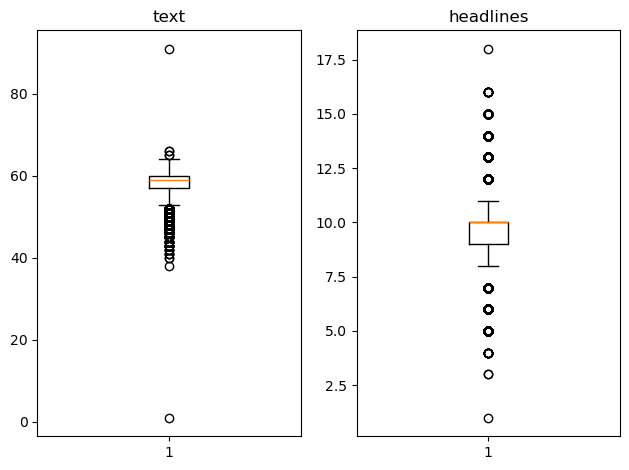

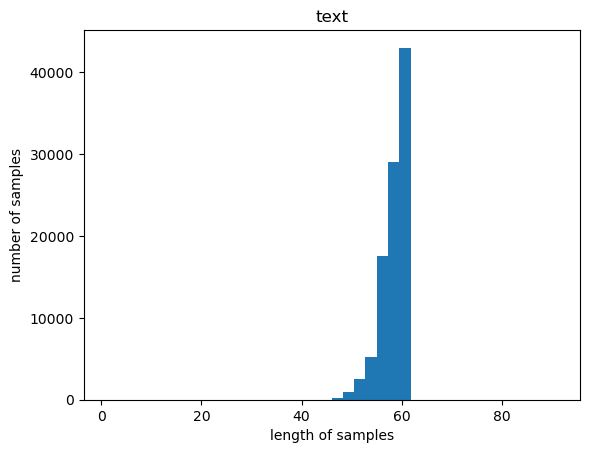

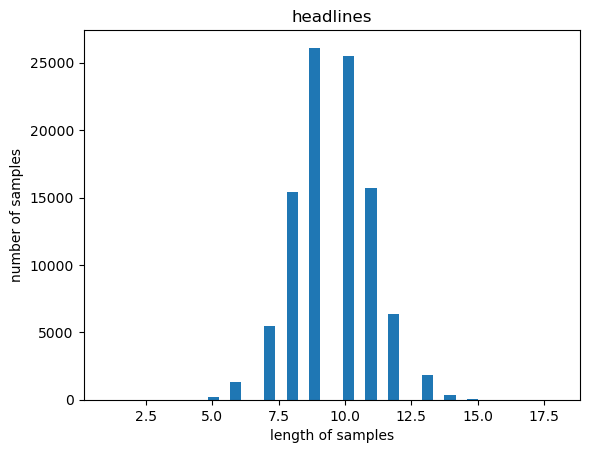

In [10]:
DataLengthVisualization(data,['text', 'headlines'])

In [11]:
# max_len 정하기
below_threshold_len([60, 11],data,['text', 'headlines'])

전체 text 샘플 중 길이가 60 이하인 샘플의 비율: 0.997449212914503
전체 headlines 샘플 중 길이가 11 이하인 샘플의 비율: 0.9121248767797075


In [12]:
# max_len을 1 내렸을 때 변화. 굉장히 크게 변화함으로 text는 60, headlines는 11이 적절
below_threshold_len([59, 10],data,['text', 'headlines'])

전체 text 샘플 중 길이가 59 이하인 샘플의 비율: 0.562565421083119
전체 headlines 샘플 중 길이가 10 이하인 샘플의 비율: 0.7526549526935702


In [13]:
# 이후 과정을 실행해 봤을 때 전처리 이후에 값이 아래 값이 더 적절해보임
text_max_len = 40
headlines_max_len = 11

전체 데이터 수 : 85843
text의 최소 길이 : 1
text의 최대 길이 : 40
text의 평균 길이 : 34.54028866651911
headlines의 최소 길이 : 1
headlines의 최대 길이 : 11
headlines의 평균 길이 : 9.125915916265742


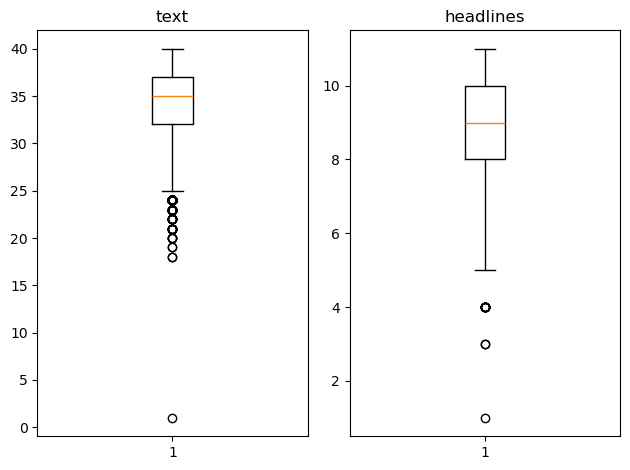

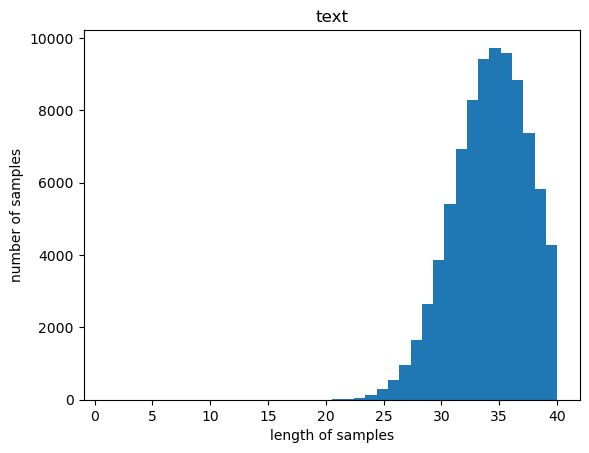

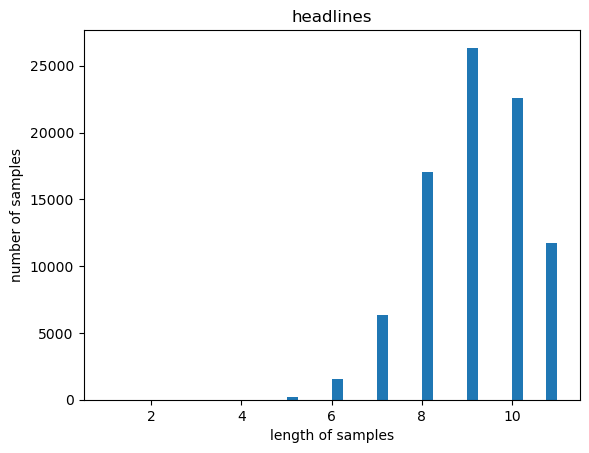

전체 text 샘플 중 길이가 40 이하인 샘플의 비율: 1.0
전체 headlines 샘플 중 길이가 11 이하인 샘플의 비율: 1.0
전체 text 샘플 중 길이가 39 이하인 샘플의 비율: 0.9502114324988642
전체 headlines 샘플 중 길이가 10 이하인 샘플의 비율: 0.8632270540405158
전체 text 샘플 중 길이가 35 이하인 샘플의 비율: 0.5820975501788148
전체 headlines 샘플 중 길이가 6 이하인 샘플의 비율: 0.021026758151509152
Done!


In [14]:
# 데이터 전처리
#================================================================================================================================================================#
train_dataset, test_dataset, src_vocab, tar_vocab = preprocessing(data.copy(), contractions, ['text', 'headlines'], [text_max_len, headlines_max_len], encode='text' ,target = 'headlines', verbose = 1)

In [15]:
#모델 생성
#================================================================================================================================================================#

embedding_dim = 128
hidden_size = 256
src_vocab_size = len(src_vocab)  # src 단어 집합 크기
tar_vocab_size = len(tar_vocab)  # tar 단어 집합 크기

# 인코더 모델 생성
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)
# 디코더 모델 생성
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)
# 모델 정의
model = Seq2Seq(encoder, decoder, tar_vocab_size)
# 모델 생성
model = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, hidden_size)

In [16]:
#Data가 전처리가 잘 되었는지 확인하기
print(train_dataset[0])
print(len(train_dataset))
print(len(test_dataset))

(tensor([1111,    8,  248, 1530, 3839,  233,   21, 4224, 5043, 5238, 2059, 1130,
        3781, 3032, 1530,    1, 5592, 4088, 1092,  535,   30,   24, 5043,    7,
         723, 3295,    1,  199,  943, 3839,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]), tensor([   2, 1084,   60,  221,    1,    4,    1,    1,    1,    5,  185,    0]), tensor([1084,   60,  221,    1,    4,    1,    1,    1,    5,  185,    3,    0]))
68675
17168


Using device: cuda
Epoch 1/300 | Train Loss: 5.5048 | Val Loss: 5.0208
Epoch 2/300 | Train Loss: 4.9860 | Val Loss: 4.9646
Epoch 3/300 | Train Loss: 4.9415 | Val Loss: 4.9271
Epoch 4/300 | Train Loss: 4.9135 | Val Loss: 4.9063
Epoch 5/300 | Train Loss: 4.8900 | Val Loss: 4.8781
Epoch 6/300 | Train Loss: 4.8494 | Val Loss: 4.8183
Epoch 7/300 | Train Loss: 4.7826 | Val Loss: 4.7494
Epoch 8/300 | Train Loss: 4.7193 | Val Loss: 4.6927
Epoch 9/300 | Train Loss: 4.6690 | Val Loss: 4.6517
Epoch 10/300 | Train Loss: 4.6253 | Val Loss: 4.6100
Epoch 11/300 | Train Loss: 4.5822 | Val Loss: 4.5630
Epoch 12/300 | Train Loss: 4.5363 | Val Loss: 4.5204
Epoch 13/300 | Train Loss: 4.4874 | Val Loss: 4.4679
Epoch 14/300 | Train Loss: 4.4355 | Val Loss: 4.4208
Epoch 15/300 | Train Loss: 4.3890 | Val Loss: 4.3836
Epoch 16/300 | Train Loss: 4.3472 | Val Loss: 4.3425
Epoch 17/300 | Train Loss: 4.3089 | Val Loss: 4.3083
Epoch 18/300 | Train Loss: 4.2750 | Val Loss: 4.2774
Epoch 19/300 | Train Loss: 4.2431 | 

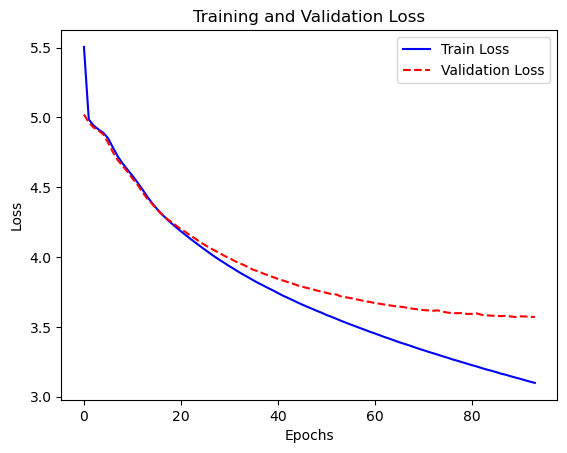

In [17]:
train_model(model,train_dataset, patience=4, epochs = 300, lr = 0.0001, train_ratio=0.9)

In [18]:
test_model(model,test_dataset)

Using device: cuda
Test Loss: 3.5764


In [19]:
#추론 모델 설계

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
decoder.to(device)

# 기존 Attention 클래스 사용
attention_layer = Attention_dot(hidden_size)
# 디코더 모델 생성
decoder_model = DecoderWithAttention(decoder, attention_layer, hidden_size, tar_vocab_size)

# 이전 시점의 상태들을 저장하는 텐서
num_layers = 3  # 디코더 LSTM 레이어 개수 (설정에 맞춰 조정)
batch_size = 1

decoder_state_input_h = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_state_input_c = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_input = torch.zeros((batch_size, 1), dtype=torch.long, device=device)

dec_emb2 = decoder.embedding(decoder_input)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder(decoder_input, decoder_state_input_h, decoder_state_input_c)

In [20]:
%%time
src_index_to_word = {idx: word for word, idx in src_vocab.items()} # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()} # 요약 단어 집합에서 정수 -> 단어를 얻음

#Extractive
for i in range(50, 80):
    print("원문 :", seq2text(test_dataset[i][0]))
    print("실제 요약 :", seq2summary(test_dataset[i][1], tar_vocab))
    input_seq = torch.tensor(test_dataset[i][0], dtype=torch.long, device=device).unsqueeze(0)
    print("예측 요약 :", decode_sequence(input_seq, encoder, decoder, tar_vocab, tar_index_to_word, text_max_len, headlines_max_len, device))
    print("\n")

원문 : nba player <UNK> <UNK> scored points team <UNK> <UNK> total match boston <UNK> friday year old became sixth player nba history score points game also beating michael jordan personal best individual score points <UNK> previous best reached thrice
실제 요약 : yr old scores <UNK> <UNK> <UNK> record still loses
예측 요약 :  it old old run run run run run sexual against


원문 : cctv footage captured moment bmw fell seven <UNK> us parking <UNK> hit another vehicle <UNK> accident reportedly occurred driver accidentally hit accelerator instead <UNK> crashing <UNK> parking <UNK> <UNK> rushed aid taken hospital
실제 요약 : <UNK> falls <UNK> from <UNK> and <UNK> driver safe
예측 요약 :  has out we we we we we we run run


원문 : actor prabhas known playing <UNK> character baahubali film franchise said even thinking marriage right present female fans need worry getting married jokingly added actor rumoured dating actress anushka shetty co starred baahubali films
실제 요약 : not even <UNK> about marriage baahubali a

<timed exec>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_1111/3064216324.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)


In [21]:
# Extractive 시도해 봤지만 안나옴
src_index_to_word = {idx: word for word, idx in src_vocab.items()} # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()} # 요약 단어 집합에서 정수 -> 단어를 얻음

for i in range(50, 60):
    print("원문 :", seq2text(test_dataset[i][0]))
    print('예측 요약:')
    print(summarize(seq2text(test_dataset[i][0]), words=5))
    print("\n")

원문 : nba player <UNK> <UNK> scored points team <UNK> <UNK> total match boston <UNK> friday year old became sixth player nba history score points game also beating michael jordan personal best individual score points <UNK> previous best reached thrice
예측 요약:



원문 : cctv footage captured moment bmw fell seven <UNK> us parking <UNK> hit another vehicle <UNK> accident reportedly occurred driver accidentally hit accelerator instead <UNK> crashing <UNK> parking <UNK> <UNK> rushed aid taken hospital
예측 요약:



원문 : actor prabhas known playing <UNK> character baahubali film franchise said even thinking marriage right present female fans need worry getting married jokingly added actor rumoured dating actress anushka shetty co starred baahubali films
예측 요약:



원문 : isro chairman <UNK> said india get internet speeds <UNK> end next year added india <UNK> launched yet launched <UNK> <UNK> <UNK> together provide high <UNK> connectivity bridge digital divide <UNK> speaking <UNK> event hyderabad
예측 요약

In [22]:
# ratio 시도해도 안나옴
for i in range(50, 60):
    print("원문 :", seq2text(test_dataset[i][0]))
    print('예측 요약:')
    print(summarize(seq2text(test_dataset[i][0]), ratio=0.4))
    print("\n")

원문 : nba player <UNK> <UNK> scored points team <UNK> <UNK> total match boston <UNK> friday year old became sixth player nba history score points game also beating michael jordan personal best individual score points <UNK> previous best reached thrice
예측 요약:



원문 : cctv footage captured moment bmw fell seven <UNK> us parking <UNK> hit another vehicle <UNK> accident reportedly occurred driver accidentally hit accelerator instead <UNK> crashing <UNK> parking <UNK> <UNK> rushed aid taken hospital
예측 요약:



원문 : actor prabhas known playing <UNK> character baahubali film franchise said even thinking marriage right present female fans need worry getting married jokingly added actor rumoured dating actress anushka shetty co starred baahubali films
예측 요약:



원문 : isro chairman <UNK> said india get internet speeds <UNK> end next year added india <UNK> launched yet launched <UNK> <UNK> <UNK> together provide high <UNK> connectivity bridge digital divide <UNK> speaking <UNK> event hyderabad
예측 요약

In [23]:
# 원문으로 시도해도 안나옴
for i in range(50, 60):
    print("원문 :", data['text'][i])
    print('예측 요약:')
    print(summarize(data['text'][i], ratio=0.4))
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
예측 요약:
Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018. 
예측 요약:
Boeing retained its positi

In [24]:
text = requests.get(url, timeout=10).text
print(text[:1500]+'...')

In 1999, in an unnamed city, Computer programmer Thomas Anderson (Keanu Reeves) is secretly a hacker known as "Neo". He is restless, eager and driven to learn the meaning of cryptic references to the "Matrix" appearing on his computer. A woman named Trinity is observing Neo, and she does so knowing that Morpheus believes that Neo is "the One".

During one of her forays, Trinity is tracked down by the local police to her hotel room. Outside the hotel a car drives up and three agents appear in neatly pressed black suits. They are Agent Smith (Hugo Weaving), Agent Brown (Paul Goddard), and Agent Jones (Robert Taylor). Trinity calls Morpheus and says that her line was tracked and Morpheus orders her to find another exit. Trinity easily defeats the six policemen sent to apprehend her, using fighting and evasion techniques that seem to defy gravity.

A fierce rooftop chase ensues with Trinity and an Agent leaping impossibly from one building to the next, astonishing the policemen left behind

In [25]:
print('Extractive Summary:')
print(summarize(text, ratio=0.01))

Extractive Summary:
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.


In [26]:
input_seq = torch.tensor(text_to_sequence([text], src_vocab, tokenizer), dtype=torch.long, device=device)
print(input_seq)
print("Abstractive Summary :")
print(decode_sequence(input_seq, encoder, decoder, tar_vocab, tar_index_to_word, text_max_len, headlines_max_len, device))

tensor([[   1,    1,    1,  ...,    1,    1, 4574]], device='cuda:0')
Abstractive Summary :
 than will will out out used ban ban ban ban


/tmp/ipykernel_1111/3064216324.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)


Abstractive 모델을 구성하여 시도해 보았지만 결과가 많이 좋지는 않았습니다. 추가적인 학습을 많이 진행해야 더 의미있는 결과를 얻을 것 같습니다. 하지만, 몇몇 단어에서 의미있는 단어가 있기는 했습니다. 비슷한 단어나 핵심단어들이 종종 등장하기는 했지만 학습이 더 필요해 보였습니다. 또한, 비교를 위해 메트릭스 시놉시스로 요약을 하였지만 거의 대부분 모르는 단어 였는지 1로 바뀌어습니다. 따라서, 결과도 이상한 결과가 나오게 되었습니다.  

Extractive 요약을 시도해보았지만 결과가 제대로 나오지 않았습니다. 찾아보니 문장을 재대로 나눌 수 없어서 2-3문장이 충족되지 않을 경우 빈 문장으로 나오게 된다고 합니다. 따라서 매트릭스 시놉시스로 요약을 하게 될 경우 요약이 잘 되는것을 볼 수 있습니다.

| 요약 방법 | 요약 내용 | 관측 내용 |
|---|---|---|
| Abstractive |than will will out out used ban ban ban ban | vocab에 단어가 없었는지 거의 대부분 1이 나옴. 내용이 이해할 수 없는 내용들로 나옴|
| Extractive | Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith. | 더 구성이 좋고 이해할 수 있는 내용으로 나옴 많은 부분에서 안전|